# Part 1 - Predicting timeseries in the real world new

Predicting in the real world is much less theoretical than we showed you in the previous BLUs. 

As with so much, experience plays a part in choosing things like tuning Hyper-Parameters and choosing models, but at the end of the day you are going to follow some best practices when you can, grid search while your CPU allows you, and avoid complicated problems with libraries and APIs whenever those present themselves.

Let's go predict some timeseries. 

In [1]:
import utils 
from sklearn.metrics import r2_score

import pandas as pd 
import numpy as np 
import statsmodels.api as sm  # <--- Yay! API! 
% matplotlib inline 

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 5)

import itertools

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)   
warnings.filterwarnings("ignore") # specify to ignore warning messages

/Users/ricardo/.virtualenvs/time_series/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
airlines = utils.load_airline_data()

# Predicting out of time 

We will start, as so often happens, with a confession

![](https://i.imgflip.com/2ab2ba.jpg)

Same dataset as we had in the previous BLU:

In [3]:
airlines = airlines[:'1957']

## Predicting the Airlines dataset in the real world

Alright! Same problem as BLU2, but this time without caring so much about low level stuff. 

Let's have some fun! 

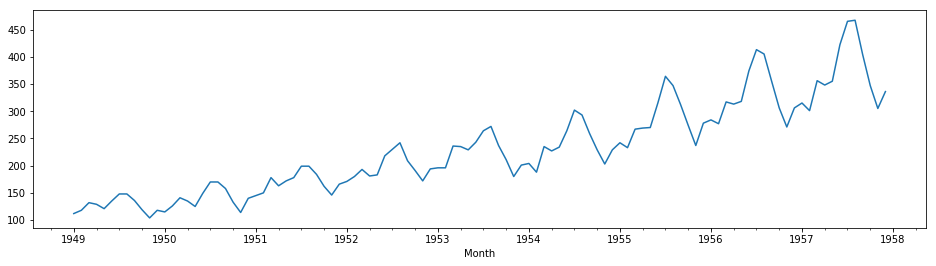

In [4]:
airlines.plot(figsize=(16, 4));

This is the SARIMAX. What does that stand for? 

![](https://i.imgflip.com/2ab2xu.jpg)

The **Autoregressive Integrated Moving Average** part we know from BLU2. _(well... kind of anyway)_ 

Now what about the new bits? 

- **`Seasonal`**: as the name suggests, this model can actually deal with seasonality. Coool.... 
- **`With Exogenous`** roughly means we can add external information. For instance we can include the temperature time series to predict the ice cream sales, which is surely useful. Exogenous variables, as you learned in [BLU2](https://github.com/LDSSA/batch2-BLU02/blob/master/Learning%20Notebooks/BLU02%20-%20Learning%20Notebook%20-%20Part%201%20of%203%20-%20Time%20series%20modelling%20concepts.ipynb)  are introduced from or produced outside the organism or system, and don't change with the predictions of the system.

What are the parameters? 

These we already know from [BLU](https://github.com/LDSSA/batch2-BLU02/blob/master/Learning%20Notebooks/BLU02%20-%20Learning%20Notebook%20-%20Part%203%20of%203%20-%20Prediction.ipynb)
> p = 0  
> d = 1  
> q = 1  

But now we have a second bunch. The first 3 are the same as before, but for the seasonal part: 
> P = 1  
> D = 1  
> Q = 1  

The last new parameter, `S`, is an integer giving the periodicity (number of periods in season). 
We normally have a decent intuition for this parameter: 
- If we have daily data and suspect we may have weekly trends, we may want `S` to be 7. 
- If the data is monthly and we think the time of the year may count, maybe try `S` at 12 
> S = 12   

To know the SARIMAX in detail you can and should take a closer look at [the documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html). But for now, let's just do exactly what we did in BLU2, but without the crazy low level details: 

In [5]:
model = sm.tsa.statespace.SARIMAX(airlines,             # <-- holy crap just passed it pandas? No ".values"? No .diff?
                          order=(0, 1, 1),              # <-- keeping our order as before in BLU2 
                          seasonal_order=(1, 1, 1, 12)) # <-- We'll get into how we found these hyper params later 

Now to fit the model 

In [6]:
results = model.fit()

And get predictions: 

In [7]:
pred = results.get_prediction(start=airlines.index.min(),  # <--- Start at the first point we have 
                              dynamic=False)               # <--- Dynamic means "use only the data 
                                                           #      from the past, we'll use this eventually 

In [8]:
mean_predictions = pred.predicted_mean

print('Can this possibly return a... %s  OH MY GOD IT DID THAT IS SO AWESOME!!' % type(mean_predictions))

Can this possibly return a... <class 'pandas.core.series.Series'>  OH MY GOD IT DID THAT IS SO AWESOME!!


Done. Seriously, check this out: 

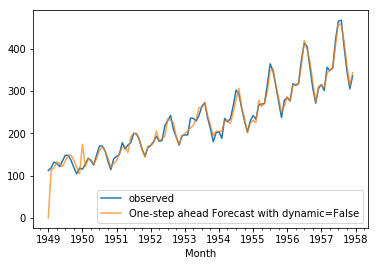

In [9]:
airlines.plot(label='observed')
mean_predictions.plot(label='One-step ahead Forecast with dynamic=False', alpha=.7)
plt.legend()
plt.show()

Boum. Confidence intervals? Why yes please: 

In [10]:
pred_ci = pred.conf_int()

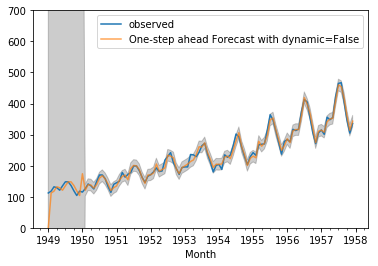

In [11]:
airlines.plot(label='observed')
mean_predictions.plot(label='One-step ahead Forecast with dynamic=False', alpha=.7)

# Let's use some matplotlib code to fill between the upper and lower confidence bound with grey 
plt.fill_between(pred_ci.index, 
                 pred_ci['lower passengers_thousands'],
                 pred_ci['upper passengers_thousands'], 
                 color='k', 
                 alpha=.2)

plt.ylim([0, 700])
plt.legend()
plt.show()

Kind of makes sense, at the start we didn't have enough data to predict much, so the uncertaintly band is pretty insane. 

In [12]:
def plot_predictions(series_, pred_):
    
    """ 
    Remember Sam told us to build functions as we go? Let's not write this stuff again. 
    """
    
    mean_predictions_ = pred_.predicted_mean

    pred_ci_ = pred_.conf_int()
    
    series_.plot(label='observed')
    mean_predictions_.plot(label='predicted', 
                           alpha=.7)

    plt.fill_between(pred_ci_.index,
                     pred_ci_['lower passengers_thousands'],
                     pred_ci_['upper passengers_thousands'], 
                     color='k', 
                     alpha=.2)

    plt.ylim([0, 700])
    plt.legend()
    plt.show()

### Now, what if we had stopped feeding it data, and asked it to predict the last 30 periods? 

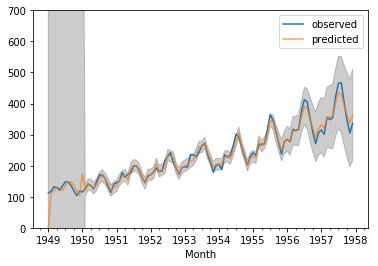

In [13]:
# We want to make 30 steps out of time 
train_up_to_step = len(airlines) - 30

# remember the dynamic argument? Well, we'll use the first 30 steps to train
pred = results.get_prediction(start=airlines.index.min(),  
                              dynamic=train_up_to_step)                     
    
plot_predictions(series_=airlines, pred_=pred)

Pretty cool, we can see the uncertainty increasing as we move. Also, what if we wanted to forecast outside of our "known" dates?

For this we will use the `get_forecast` method, which allows us to go beyond what data we have:

In [14]:
forecast = results.get_forecast(steps=15)
forecast_ci = forecast.conf_int()

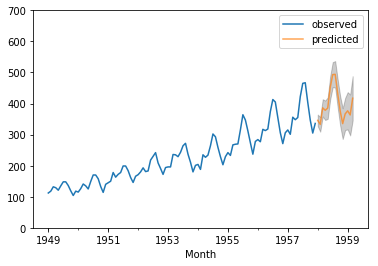

In [15]:
plot_predictions(series_=airlines, pred_=forecast)

Looks like a decent forecast! [Or is it](https://thumbs.gfycat.com/BitterRingedGrayling-size_restricted.gif)? Let's quantify the quality of our predictions. 

## Validation metrics 

There are two metrics we will use to validate our results. 

The first one,  $R^{2}$, should be familiar to you from [SLU12](https://goo.gl/6Nvqgs). It is generally used only to validate the test set results. 

_Optional bit: The demonstration of why $R^{2}$ is beyond the scope here, but intuitive enough: a really complex model can overfit and get a high $R^{2}$, so if we use it as a metric to optimize when choosing the model we're incentivizing it to overfit._

Let's evaluate some test set results with R2: 

In [16]:
pred = results.get_prediction(start=train_up_to_step, 
                              dynamic=False)

In [17]:
y_pred = pred.predicted_mean
y_true = airlines.iloc[train_up_to_step::]

In [18]:
# Compute the mean square error
r2 = r2_score(y_pred=y_pred, y_true=y_true)
print('The R2 of our forecasts is {}'.format(round(r2, 2)))

The R2 of our forecasts is 0.97


## AIC 

As we mentioned, $R^{2}$ is limited when applied to the training set. This is where AIC is a better choice. 

AIC (Akaike information criterion) is a metric that will simutaneously measure how well the model fits the data, but will control for how complex the model is. If the model is very complex, the expectation oh how well it must fit the data will also go up. It is therefore useful for comparing models. 

If you (for some weird reason) feel compelled to calculate it by hand, [this post](https://stats.stackexchange.com/questions/87345/calculating-aic-by-hand-in-r?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa) explains how to do so. Then again, it's sunny and beautiful outside, and Statsmodel has got your back. 


In [19]:
results.aic

706.3788893424502

## Hyper parameter optimization

Now, I've been using some very specific parameters: 

> p = 0  
> d = 1  
> q = 1  
> P = 1  
> D = 1  
> Q = 1  
> S = 12   

I discovered these parameters by doing one of the following: 
> A) _~~developing a strong intuition about how statsmodels work and about the trends in the airline industry~~_   
> B) throwing a hyper parameter optimizer at the problem and making myself a nice cup of tea while it ran. 

Let's build a Hyper Parameter Optimizer (fancy!) 

In [20]:
p = d = q = P = D = Q = range(0, 2)   #  <--- all of the paramters between 0 and 2 

S = [7, 14] # <-- let's pretend we have a couple of hypothesis 

In [21]:
params_combinations = list(itertools.product(p, d, q, P, D, Q, S))

In [22]:
inputs = [[x[0], x[1], x[2], x[3], x[4], x[5], x[6]] for x in params_combinations]

Great. Now, for each set of params, let's get the aic: 

In [23]:
def get_aic(series_, params):
    # extract the params 
    p = params[0] 
    d = params[1] 
    q = params[2] 
    P = params[3]
    D = params[4] 
    Q = params[5]
    S = params[6]
    
    # fit a model with those params 
    model = sm.tsa.statespace.SARIMAX(series_,
                                      order=(p, d, q),
                                      seasonal_order=(P, D, Q, S),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    
    # fit the model
    results = model.fit()
    
    # return the aic 
    return results.aic

Run, forest, run! 

In [24]:
%%time 

aic_scores = {}
params_index = {}

for i in range(len(inputs)):
    try: 
        param_set = inputs[i]
        aic = get_aic(airlines, param_set) 
        aic_scores[i] = aic
        params_index[i] = param_set
    
    # this will fail sometimes with impossible parameter combinations. 
    # ... and I'm too lazy to remember what they are. 
    except Exception as e: 
        continue

CPU times: user 33.7 s, sys: 1.87 s, total: 35.5 s
Wall time: 41.8 s


Wrangle these results into a usable dataframe 

_(note: don't worry if you don't understand this code too well for now)_

In [25]:
temp = pd.DataFrame(params_index).T
temp.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'S']
temp['aic'] = pd.Series(aic_scores)
temp.sort_values('aic').head()

,p,d,q,P,D,Q,S,aic
119,1,1,1,0,1,1,14,749.362161
127,1,1,1,1,1,1,14,751.354183
55,0,1,1,0,1,1,14,751.422741
63,0,1,1,1,1,1,14,753.411938
95,1,0,1,1,1,1,14,761.610289


Great! What were the best params? 

In [26]:
best_model_params = temp.aic.idxmin()
temp.loc[best_model_params]

p        1.000000
d        1.000000
q        1.000000
P        0.000000
D        1.000000
Q        1.000000
S       14.000000
aic    749.362161
Name: 119, dtype: float64

Great! Let's fit that model then: 

In [27]:
best_model = sm.tsa.statespace.SARIMAX(airlines,
                                      order=(0, 1, 1),
                                      seasonal_order=(1, 1, 1, 12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)

results = best_model.fit()
predictions_best_model = results.get_prediction(dynamic=len(airlines) - 10)

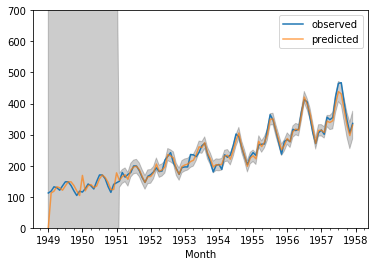

In [28]:
plot_predictions(series_=airlines, pred_=predictions_best_model)

# Using season and exogenous variables

So far, we have been using only the endogenous variable to create predictions. Also, the time series we used are ... kind of easy. Highly seasonal and periodic, eventhough the variance might increase over time. But they are easy. So, what about making things a "little bit" harder? Like, for example, predicting the US GDP Growth.

In [29]:
import pandas as pd

from statsmodels import api as sm

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

If you want additional insights on each of the time series of this dataset, check this page at [thebalance.com](https://www.thebalance.com/components-of-gdp-explanation-formula-and-chart-3306015).

In [30]:
data = pd.read_csv('../data/US_Production_Q_Data_Growth_Rates.csv')

data.Year = pd.to_datetime(data.Year)

data = data.set_index('Year')

data.head(10)

,GDP Growth,Consumption Growth,Investment Growth,Government Purchases Growth,Exports Growth,Imports Growth,Capital Growth,Labor Growth
Year,,,,,,,,
1948-01-01,2.8,2.4,21.1,-3.6,-14.8,18.4,3.5,1.9
1948-04-01,4.5,2.7,32.0,1.0,-30.6,14.1,3.8,1.8
1948-07-01,5.2,2.0,34.9,5.9,-29.0,25.1,4.2,2.3
1948-10-01,3.8,2.2,13.4,11.9,-22.5,15.8,4.7,0.4
1949-01-01,0.9,1.2,-11.6,14.4,-7.3,-2.5,4.9,-2.0
1949-04-01,-1.0,1.8,-33.5,15.4,2.0,-6.8,4.6,-3.6
1949-07-01,-0.5,2.1,-26.7,13.9,-7.1,-14.8,4.0,-5.4
1949-10-01,-1.5,3.3,-29.4,8.8,-16.8,-8.4,3.5,-4.8
1950-01-01,3.8,5.1,9.7,2.5,-30.3,0.6,3.0,-2.4


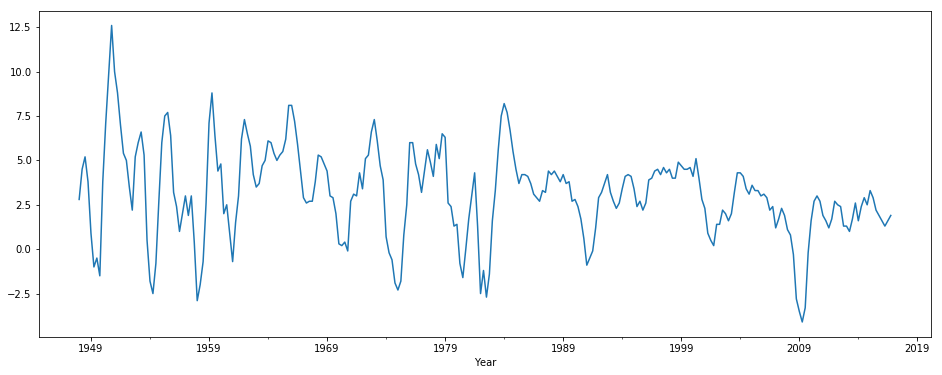

In [31]:
data['GDP Growth'].plot(figsize=(16, 6));

Can you see any seasonality? Me neither. But you might notice that, from time to time, there is a big drop in GDP Growth (to negative values). That is related to economical cycles. Hmmm...cycles...maybe a cyclical component is present?

**ALSO**, Remember the 2007 crisis? Well, it is no surprise that we had the biggest recession near ~2009. 

Let's plot all time series together to see if there is a pattern

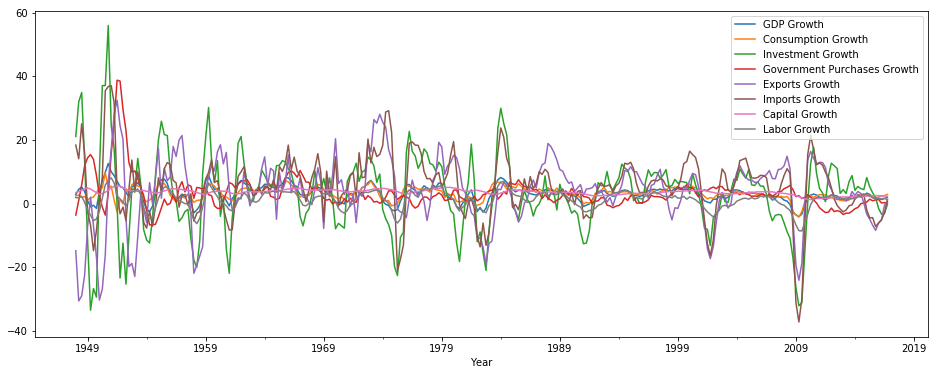

In [32]:
data.plot(figsize=(16, 6));

Well...maybe it wasn't a good idea. Let's instead make several plots, one for each pair (GDP Growth, OTHER TIME SERIES)

In [33]:
from itertools import product

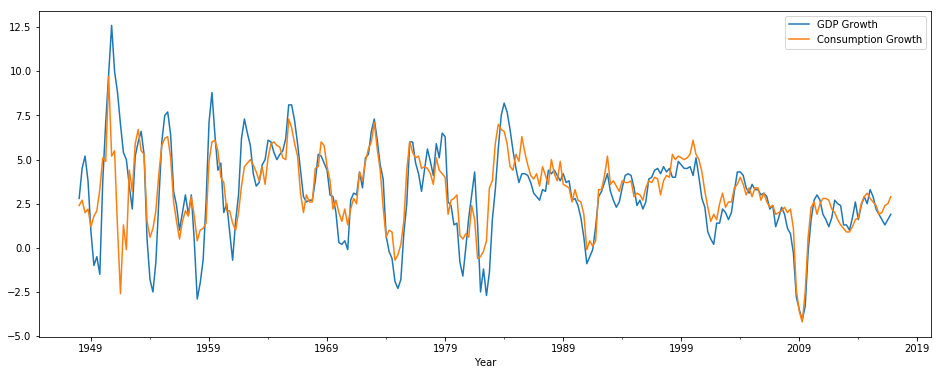

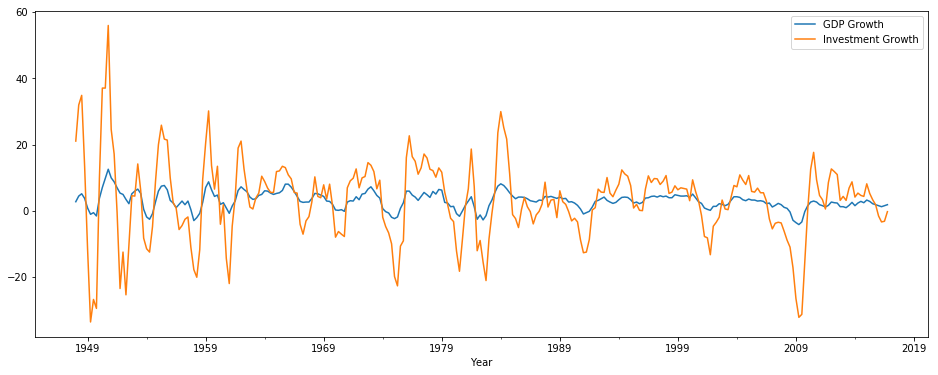

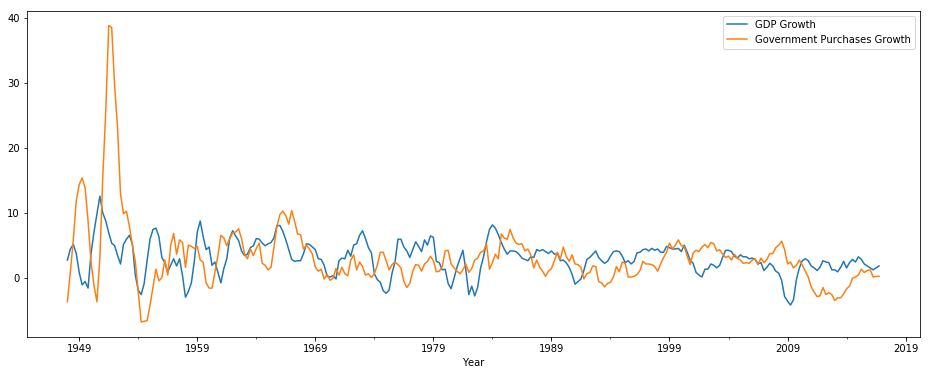

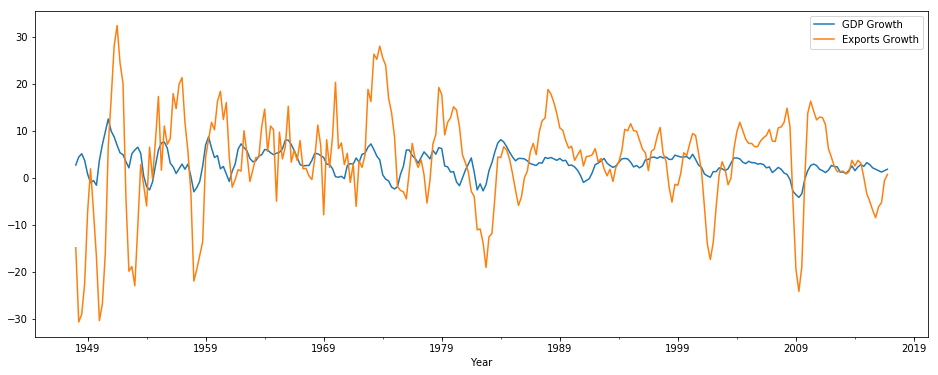

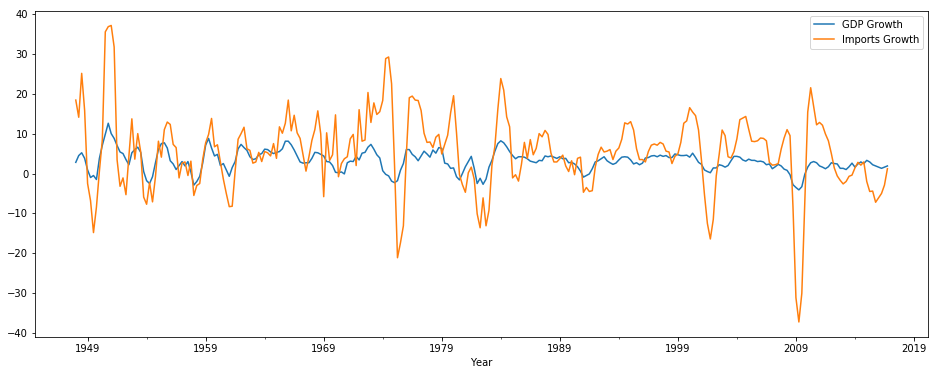

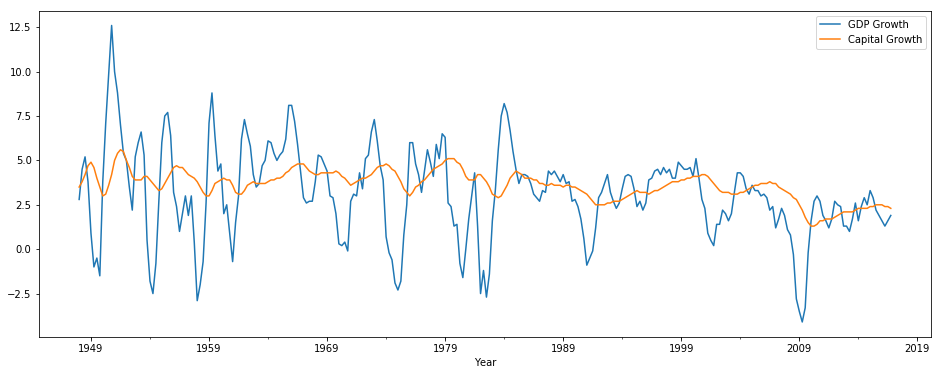

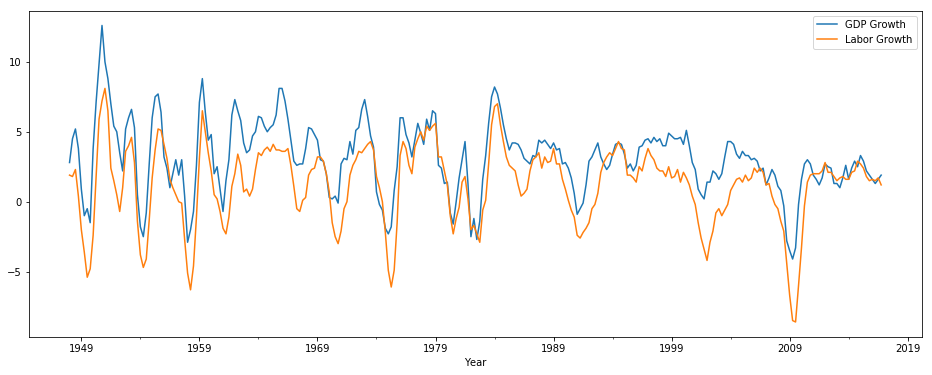

In [34]:
for gdp, other in product(['GDP Growth'], data.drop('GDP Growth', axis=1).columns): 
    data[[gdp, other]].plot(figsize=(16, 6))
    plt.show()

By visual inspection, we that Consumption Growth and Labor Growth follow GDP Growth like two puppies. So, one reasonable hypothesis is: those two time series are highly predictive for GDP Growth. Instead of trying to find the best model using grid search, we will let you explore the effect of each exogenous variable and model parameter in the forecast. 

First, let's prepare the train test split and, also, add some cyclical features for month and decade

In [35]:
import numpy as np


X = data.drop('GDP Growth', axis=1)
X['month (cosine)'] = np.cos(2 * np.pi * X.index.month/ 12)
X['month (sin)'] = np.sin(2 * np.pi * X.index.month/ 12)
X['decade (cosine)'] = np.cos(2 * np.pi * (X.index.year % 10) / 10)
X['decade (sine)'] = np.sin(2 * np.pi * (X.index.year % 10) / 10)

y = data['GDP Growth']

train_percentage = 0.5
train_size = int(X.shape[0] * train_percentage)

X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
X_test, y_test = X.iloc[train_size:], y.iloc[train_size:]

In [36]:
from ipywidgets import interact
from ipywidgets import fixed
from ipywidgets import FloatSlider
from ipywidgets import IntSlider
from ipywidgets import Checkbox
from ipywidgets import Dropdown
from ipywidgets import SelectMultiple

In [37]:
def sarimax_fit_and_plot(endo_train, endo_test, 
                         exog_train=None, exog_test=None, 
                         use_exog=False, 
                         exog_selected=None, 
                         trend='n', 
                         maxiter=50,
                         forecast_steps=None, 
                         p=1, d=0, q=0, 
                         P=0, D=0, Q=0, s=0):
    if use_exog:
        exog_selected = list(exog_selected)
    
        exog_train = exog_train[exog_selected]
        exog_test = exog_test[exog_selected]
    
    if use_exog:
        sarimax = sm.tsa.SARIMAX(endo_train, exog=exog_train, 
                                 order=(p, d, q), trend=trend, 
                                 seasonal_order=(P, D, Q, s))
    else:
        sarimax = sm.tsa.SARIMAX(endo_train, 
                                 order=(p, d, q), trend=trend, 
                                 seasonal_order=(P, D, Q, s))

    sarimax_results = sarimax.fit(maxiter=maxiter, 
                                  trend=trend)
    
    if forecast_steps is None:
        forecast_steps = len(y_test)
        
    if use_exog:
        exog_test = exog_test.iloc[:forecast_steps]
        forecast = sarimax_results.get_forecast(
            steps=forecast_steps, exog=exog_test).predicted_mean
    else:
        forecast = sarimax_results.get_forecast(
            steps=forecast_steps).predicted_mean
    
    plot_forecast_target(forecast, endo_test)


def plot_forecast_target(forecast, target):
    plt.figure(figsize=(16, 6))
    forecast.plot(label="prediction")
    target = target.iloc[:len(forecast)]
    target.plot(label="target")
    plt.ylabel(target.name)
    plt.legend()
    plt.title("R²: {}".format(r2_score(target, forecast)))

In [38]:
interact(sarimax_fit_and_plot, 
         endo_train=fixed(y_train), 
         endo_test=fixed(y_test), 
         exog_train=fixed(X_train), 
         exog_test=fixed(X_test), 
         use_exog=Dropdown(options=[True, False]), 
         exog_selected=SelectMultiple(
             options=list(X.columns),
             value=[X.columns[0]], 
             rows=X.shape[1],
             description='Exogenous features',
             disabled=False
         ), 
         trend=Dropdown(options=['n','c','t','ct']), 
         maxiter=IntSlider(value=50, 
                           min=10, 
                           max=5000, 
                           step=10), 
         forecast_steps=IntSlider(value=10, 
                                  min=1, 
                                  max=len(y_test), 
                                  step=1), 
         p=IntSlider(value=1, 
                     min=0, 
                     max=20, 
                     step=1), 
         d=IntSlider(value=0, 
                     min=0, 
                     max=2, 
                     step=1), 
         q=IntSlider(value=0, 
                     min=0, 
                     max=10, 
                     step=1), 
         P=IntSlider(value=0, 
                     min=0, 
                     max=10, 
                     step=1), 
         D=IntSlider(value=0, 
                     min=0, 
                     max=2, 
                     step=1), 
         Q=IntSlider(value=0, 
                     min=0, 
                     max=10, 
                     step=1), 
         s=IntSlider(value=0, 
                     min=0, 
                     max=40, 
                     step=1));

interactive(children=(Dropdown(description='use_exog', options=(True, False), value=True), SelectMultiple(desc…

**NOTE**: if your CPU starts to cry for help, press stop to interrupt the execution and change the parameters.